In [ ]:
# USAGE
# python train.py
# import the necessary packages
from bbox_regressor import ObjectDetector
from custom_tensor_dataset import CustomTensorDataset
import config
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torch.optim import lr_scheduler
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import time
import cv2
import os
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
print("[INFO] loading dataset...")

[INFO] loading dataset...


In [ ]:
data_test = []
labels_test = []
bboxes_test = []
imagePaths_test = []
# loop over all CSV files in the annotations directory
for csvPath in paths.list_files(config.ANNOTS_PATH_VALID, validExts=(".txt")):
  # load the contents of the current CSV annotations file
  #print(csvPath)
  file_name = os.path.splitext(csvPath)[0]
  file_name = file_name.split("/")
  file_name = file_name[5]
  image_path = '/content/DialysisMachines/valid/images/' + file_name + '.jpg'
  image = cv2.imread(image_path)
  #print(image_path)
  rows = open(csvPath).read().strip().split("\n")
  
  #print(rows)
  # loop over the rows
  for row in rows:
    # break the row into the filename, bounding box coordinates,
    # and class label
    #print(i)
    row = row.split(" ")
    #print(row)
    (label, startX, startY, endX, endY) = row

    labels_test.append(label)
    bboxes_test.append((startX, startY, endX, endY))
    imagePaths_test.append(image_path)
    data_test.append(image)

# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays
data_test = np.array(data_test, dtype="float32")
labels_test = np.array(labels_test)
bboxes_test = np.array(bboxes_test, dtype="float32")
imagePaths_test = np.array(imagePaths_test)
# perform label encoding on the labels
le = LabelEncoder()
labels_test = le.fit_transform(labels_test)
# convert NumPy arrays to PyTorch tensors
testImages = torch.tensor(data_test)
testLabels = torch.tensor(labels_test)
testBBoxes = torch.tensor(bboxes_test)
transformes = transforms.Compose([
	transforms.ToPILImage(),
	transforms.ToTensor(),
	transforms.Normalize(mean=config.MEAN, std=config.STD)
])
testDS = CustomTensorDataset((testImages, testLabels, testBBoxes),transforms=transformes)
print("[INFO] total testing samples: {}...".format(len(testDS)))
testLoader = DataLoader(testDS, batch_size=config.BATCH_SIZE,
	num_workers=os.cpu_count(), pin_memory=config.PIN_MEMORY)

[INFO] total testing samples: 87...


In [ ]:
data_train = []
labels_train = []
bboxes_train = []
imagePaths_train = []
# loop over all CSV files in the annotations directory
for csvPath in paths.list_files(config.ANNOTS_PATH_TRAIN, validExts=(".txt")):
  # load the contents of the current CSV annotations file
  #print(csvPath)
  file_name = os.path.splitext(csvPath)[0]
  file_name = file_name.split("/")
  file_name = file_name[5]
  image_path = '/content/DialysisMachines/train/images/' + file_name + '.jpg'
  image = cv2.imread(image_path)
  #print(image_path)
  rows = open(csvPath).read().strip().split("\n")
  
  #print(rows)
  # loop over the rows
  for row in rows:
    # break the row into the filename, bounding box coordinates,
    # and class label
    #print(i)
    row = row.split(" ")
    #print(row)
    (label, startX, startY, endX, endY) = row

    labels_train.append(label)
    bboxes_train.append((startX, startY, endX, endY))
    imagePaths_train.append(image_path)
    data_train.append(image)

# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays
data_train = np.array(data_train, dtype="float32")
labels_train = np.array(labels_train)
bboxes_train = np.array(bboxes_train, dtype="float32")
imagePaths_train = np.array(imagePaths_train)
# perform label encoding on the labels
le = LabelEncoder()
labels_train = le.fit_transform(labels_train)
# convert NumPy arrays to PyTorch tensors
trainImages = torch.tensor(data_train)
trainLabels = torch.tensor(labels_train)
trainBBoxes = torch.tensor(bboxes_train)
transformes = transforms.Compose([
	transforms.ToPILImage(),
	transforms.ToTensor(),
	transforms.Normalize(mean=config.MEAN, std=config.STD)
])
trainDS = CustomTensorDataset((trainImages, trainLabels, trainBBoxes),transforms=transformes)
print("[INFO] total training samples: {}...".format(len(trainDS)))
trainLoader = DataLoader(trainDS, batch_size=config.BATCH_SIZE,
	shuffle=True, num_workers=os.cpu_count(), pin_memory=config.PIN_MEMORY)

[INFO] total training samples: 849...


In [ ]:
# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // config.BATCH_SIZE
valSteps = len(testDS) // config.BATCH_SIZE

In [ ]:
# load the ResNet50 network
resnet = resnet50(pretrained=True)
# freeze all ResNet50 layers so they will *not* be updated during the
# training process
for param in resnet.parameters():
	param.requires_grad = False

# a = resnet.fc.in_features
# print(a)

In [ ]:
# create our custom object detector model and flash it to the current
# device
objectDetector = ObjectDetector(resnet, len(le.classes_))
objectDetector = objectDetector.to(config.DEVICE)
# define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(objectDetector.parameters(), lr=config.INIT_LR)
#print(objectDetector)
#Scheduler has been used since the validation loss is not decreasing
step_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
# initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],
	 "val_class_acc": []}

In [ ]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
  # set the model in training mode
  objectDetector.train()
  # initialize the total training and validation loss
  totalTrainLoss = 0
  totalValLoss = 0
  # initialize the number of correct predictions in the training
  # and validation step
  trainCorrect = 0
  valCorrect = 0

  # loop over the training set
  for (images, labels, bboxes) in trainLoader:
    # send the input to the device
    (images, labels, bboxes) = (images.to(config.DEVICE),
      labels.to(config.DEVICE), bboxes.to(config.DEVICE))
    # perform a forward pass and calculate the training loss
    predictions = objectDetector(images)
    bboxLoss = bboxLossFunc(predictions[0], bboxes)
    classLoss = classLossFunc(predictions[1], labels)
    totalLoss = (config.BBOX * bboxLoss) #+ (config.LABELS * classLoss)
    # zero out the gradients, perform the backpropagation step,
    # and update the weights
    opt.zero_grad()
    totalLoss.backward()
    opt.step()
    # add the loss to the total training loss so far and
    # calculate the number of correct predictions
    totalTrainLoss += totalLoss
    trainCorrect += (predictions[1].argmax(1) == labels).type(
      torch.float).sum().item()
   

  with torch.no_grad():
    # set the model in evaluation mode
    objectDetector.eval()
    # loop over the validation set
    for (images, labels, bboxes) in testLoader:
      # send the input to the device
      (images, labels, bboxes) = (images.to(config.DEVICE),
        labels.to(config.DEVICE), bboxes.to(config.DEVICE))
      # make the predictions and calculate the validation loss
      predictions = objectDetector(images)
      bboxLoss = bboxLossFunc(predictions[0], bboxes)
      classLoss = classLossFunc(predictions[1], labels)
      totalLoss = (config.BBOX * bboxLoss) #+ (config.LABELS * classLoss)
      totalValLoss += totalLoss
      # calculate the number of correct predictions
      valCorrect += (predictions[1].argmax(1) == labels).type(
        torch.float).sum().item()
  

  step_lr_scheduler.step()

  # calculate the average training and validation loss
  avgTrainLoss = totalTrainLoss / trainSteps
  avgValLoss = totalValLoss / valSteps
  # calculate the training and validation accuracy
  trainCorrect = trainCorrect / len(trainDS)
  valCorrect = valCorrect / len(testDS)
  # update our training history
  H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["train_class_acc"].append(trainCorrect)
  H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
  H["val_class_acc"].append(valCorrect)
  # print the model training and validation information
  print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
    avgTrainLoss, trainCorrect))
  print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
    avgValLoss, valCorrect))
  

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  5%|▌         | 1/20 [00:04<01:23,  4.40s/it]

[INFO] EPOCH: 1/20
Train loss: 0.041804, Train accuracy: 1.0000
Val loss: 0.037307, Val accuracy: 1.0000


 10%|█         | 2/20 [00:08<01:17,  4.29s/it]

[INFO] EPOCH: 2/20
Train loss: 0.022307, Train accuracy: 1.0000
Val loss: 0.036943, Val accuracy: 1.0000


 15%|█▌        | 3/20 [00:12<01:12,  4.28s/it]

[INFO] EPOCH: 3/20
Train loss: 0.021624, Train accuracy: 1.0000
Val loss: 0.037502, Val accuracy: 1.0000


 20%|██        | 4/20 [00:17<01:08,  4.27s/it]

[INFO] EPOCH: 4/20
Train loss: 0.021190, Train accuracy: 1.0000
Val loss: 0.035139, Val accuracy: 1.0000


 25%|██▌       | 5/20 [00:21<01:05,  4.35s/it]

[INFO] EPOCH: 5/20
Train loss: 0.020729, Train accuracy: 1.0000
Val loss: 0.035300, Val accuracy: 1.0000


 30%|███       | 6/20 [00:26<01:01,  4.36s/it]

[INFO] EPOCH: 6/20
Train loss: 0.020510, Train accuracy: 1.0000
Val loss: 0.036277, Val accuracy: 1.0000


 35%|███▌      | 7/20 [00:30<00:56,  4.34s/it]

[INFO] EPOCH: 7/20
Train loss: 0.020127, Train accuracy: 1.0000
Val loss: 0.033684, Val accuracy: 1.0000


 40%|████      | 8/20 [00:34<00:52,  4.34s/it]

[INFO] EPOCH: 8/20
Train loss: 0.019851, Train accuracy: 1.0000
Val loss: 0.033893, Val accuracy: 1.0000


 45%|████▌     | 9/20 [00:39<00:47,  4.35s/it]

[INFO] EPOCH: 9/20
Train loss: 0.019783, Train accuracy: 1.0000
Val loss: 0.033906, Val accuracy: 1.0000


 50%|█████     | 10/20 [00:43<00:43,  4.37s/it]

[INFO] EPOCH: 10/20
Train loss: 0.019809, Train accuracy: 1.0000
Val loss: 0.034092, Val accuracy: 1.0000


 55%|█████▌    | 11/20 [00:47<00:39,  4.37s/it]

[INFO] EPOCH: 11/20
Train loss: 0.019810, Train accuracy: 1.0000
Val loss: 0.034013, Val accuracy: 1.0000


 60%|██████    | 12/20 [00:52<00:34,  4.36s/it]

[INFO] EPOCH: 12/20
Train loss: 0.019770, Train accuracy: 1.0000
Val loss: 0.033546, Val accuracy: 1.0000


 65%|██████▌   | 13/20 [00:56<00:30,  4.34s/it]

[INFO] EPOCH: 13/20
Train loss: 0.019619, Train accuracy: 1.0000
Val loss: 0.033877, Val accuracy: 1.0000


 70%|███████   | 14/20 [01:00<00:26,  4.35s/it]

[INFO] EPOCH: 14/20
Train loss: 0.019478, Train accuracy: 1.0000
Val loss: 0.033493, Val accuracy: 1.0000


 75%|███████▌  | 15/20 [01:05<00:21,  4.34s/it]

[INFO] EPOCH: 15/20
Train loss: 0.019374, Train accuracy: 1.0000
Val loss: 0.033578, Val accuracy: 1.0000


 80%|████████  | 16/20 [01:09<00:17,  4.33s/it]

[INFO] EPOCH: 16/20
Train loss: 0.019637, Train accuracy: 1.0000
Val loss: 0.033591, Val accuracy: 1.0000


 85%|████████▌ | 17/20 [01:13<00:12,  4.32s/it]

[INFO] EPOCH: 17/20
Train loss: 0.019592, Train accuracy: 1.0000
Val loss: 0.033605, Val accuracy: 1.0000


 90%|█████████ | 18/20 [01:18<00:08,  4.31s/it]

[INFO] EPOCH: 18/20
Train loss: 0.019507, Train accuracy: 1.0000
Val loss: 0.033547, Val accuracy: 1.0000


 95%|█████████▌| 19/20 [01:22<00:04,  4.30s/it]

[INFO] EPOCH: 19/20
Train loss: 0.019529, Train accuracy: 1.0000
Val loss: 0.033616, Val accuracy: 1.0000


100%|██████████| 20/20 [01:26<00:00,  4.33s/it]

[INFO] EPOCH: 20/20
Train loss: 0.019583, Train accuracy: 1.0000
Val loss: 0.033501, Val accuracy: 1.0000
[INFO] total time taken to train the model: 86.58s


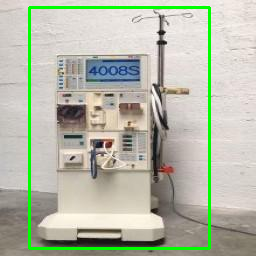

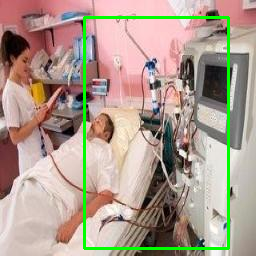

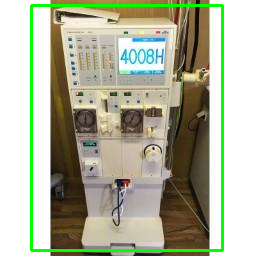

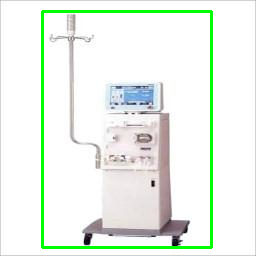

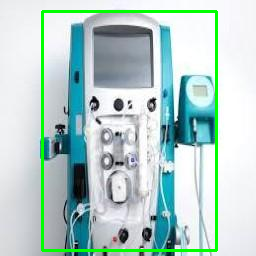

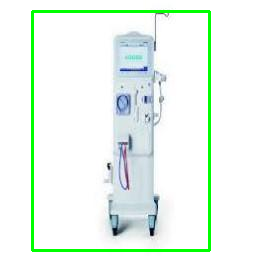

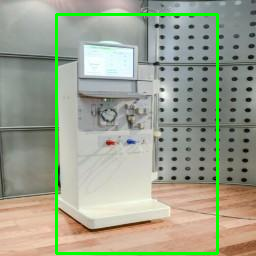

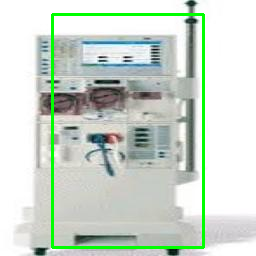

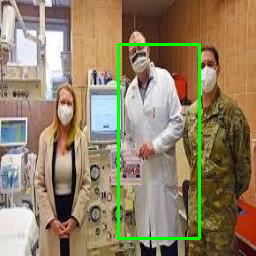

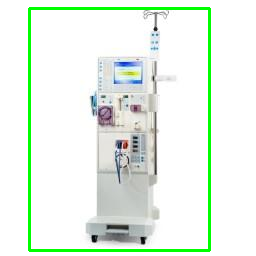

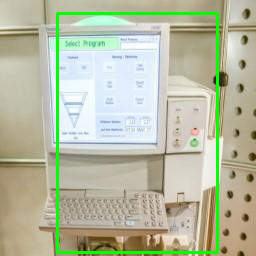

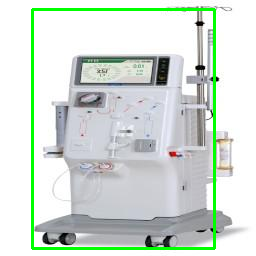

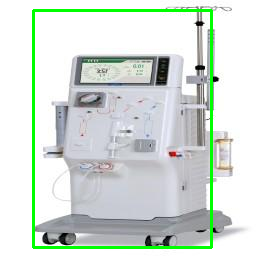

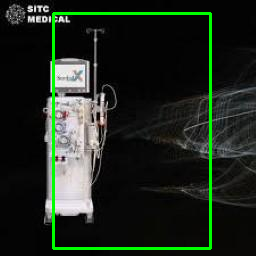

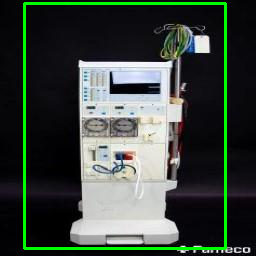

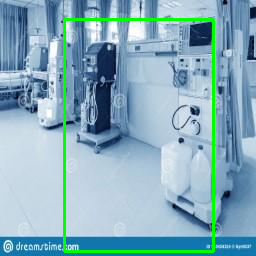

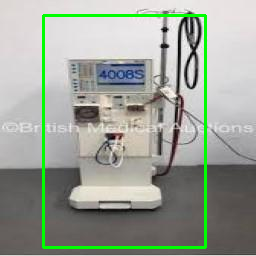

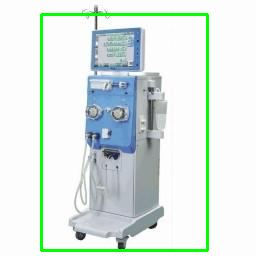

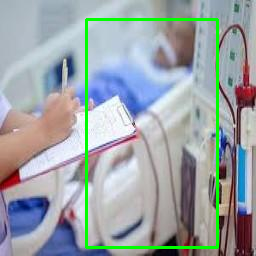

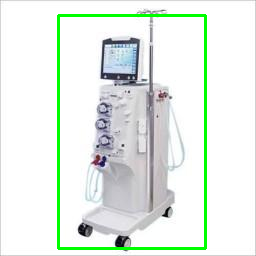

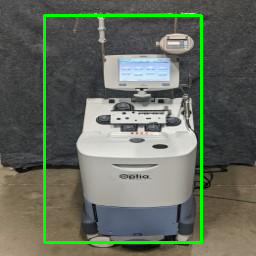

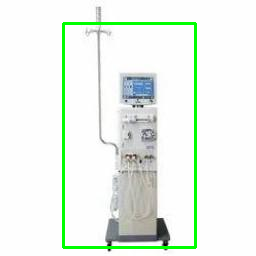

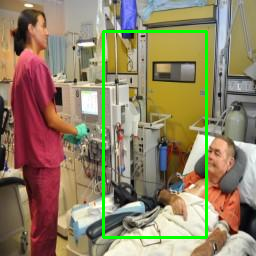

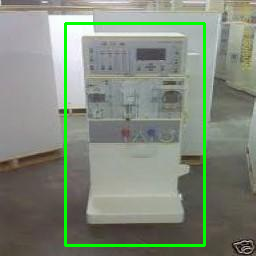

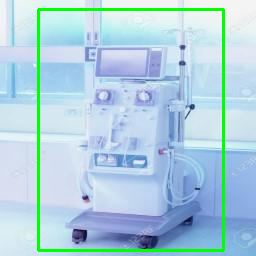

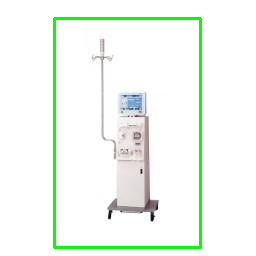

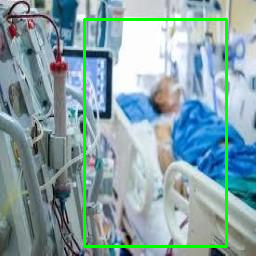

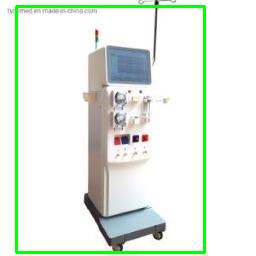

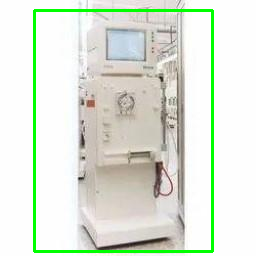

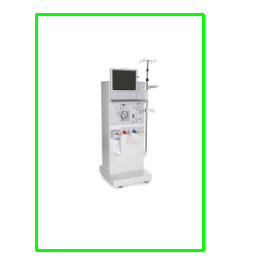

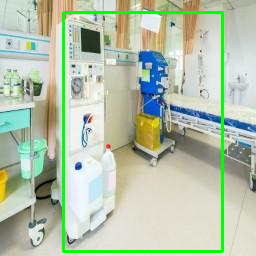

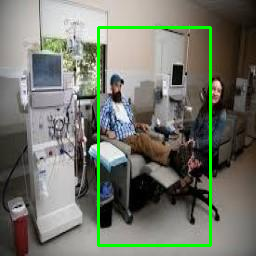

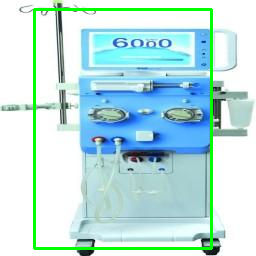

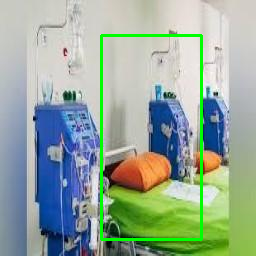

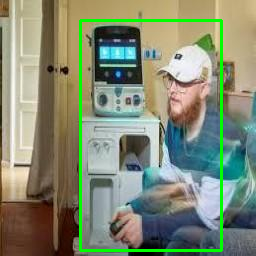

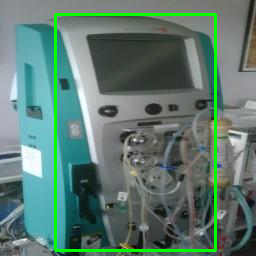

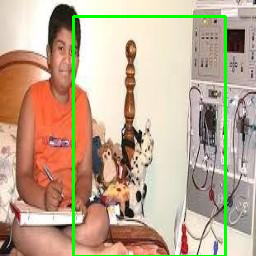

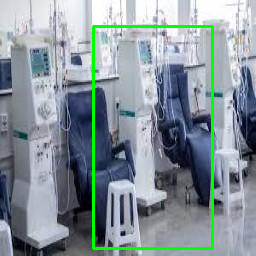

In [ ]:
from google.colab.patches import cv2_imshow
with torch.no_grad():
  # set the model in evaluation mode
  objectDetector.eval()
  # loop over the validation set
  for imagepaths in os.listdir('/content/DialysisMachines/test/images'):
    imagepaths = '/content/DialysisMachines/test/images/' + imagepaths
    image_cv = cv2.imread(imagepaths)
    #cv2_imshow(image_cv)
    orig = image_cv.copy()
    image = image_cv.transpose((2, 0, 1))
    test_transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(),transforms.Normalize(mean=config.MEAN, std=config.STD)])
    image = torch.from_numpy(image)
    image = test_transform(image).to(config.DEVICE)
    image = image.unsqueeze(0)
    (boxPreds, labelPreds) = objectDetector(image)
    (startX, startY, endX, endY) = boxPreds[0]
    (h, w) = orig.shape[:2]
    startX = float(startX)
    startY = float(startY)
    endX = float(endX)
    endY = float(endY)
    midX = int(startX * 256)
    midY = int(startY * 256)
    width = int(endX * 256)
    height = int(endY * 256)
    startX = midX - (width/2)
    endX = midX + (width/2)
    startY = midY - (height/2)
    endY = midY + (height/2)
    startX = int(startX)
    startY = int(startY)
    endX = int(endX)
    endY = int(endY)
    cv2.rectangle(orig, (startX, startY), (endX, endY),
      (0, 255, 0), 2)
    cv2_imshow(orig)
  